In [554]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import squarify
import random
import warnings
%matplotlib inline
# Ignore all warnings
warnings.filterwarnings("ignore")

# load the data
data = pd.read_csv('mushrooms.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [555]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


# Treemap Graph
The treemap graph visualizes the distribution of mushroom classes based on the combination of two variables: 'veil-color' and 'spore-print-color'. Each rectangle in the treemap represents a unique combination of these variables, and its size corresponds to the count of occurrences.

This graph is added just for visual illustration of a part of the data, it is not needed for our data analytics.


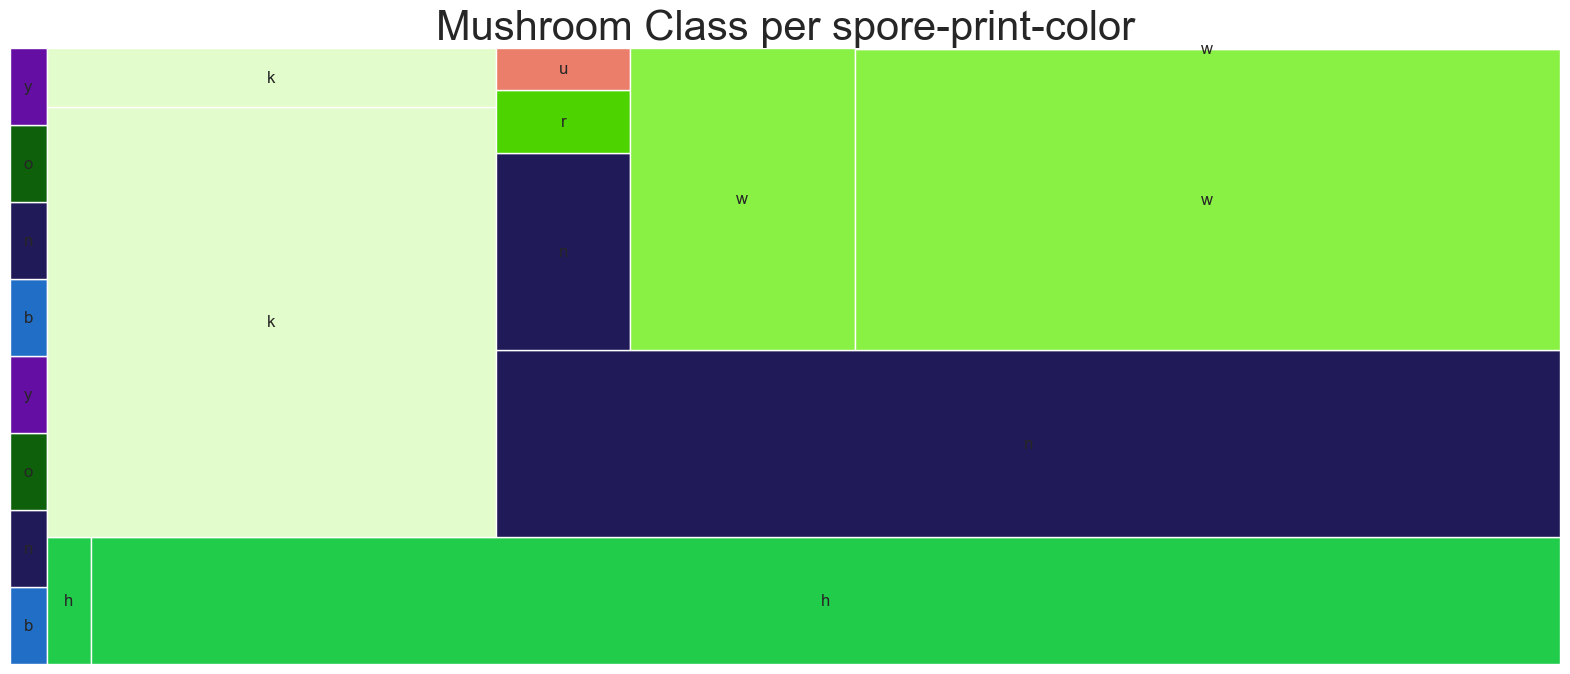

In [556]:

# Create the subdata3 dataframe
sub_data = data.groupby(['veil-color', 'spore-print-color', 'class']).size().reset_index(name='count')


# Assign random colors to each unique value in the 'spore-print-color' column
unique_colors = ['#' + '%06x' % random.randint(0, 0xFFFFFF) for _ in sub_data['spore-print-color'].unique()]
color_map = dict(zip(sub_data['spore-print-color'].unique(), unique_colors))
sub_data['color'] = sub_data['spore-print-color'].map(color_map)

# Set the plot size
fig, ax = plt.subplots(figsize=(20, 8))

# Generate the treemap plot
squarify.plot(sizes=sub_data['count'], label=sub_data['spore-print-color'], color=sub_data['color'], ax=ax)

# Customize the plot
plt.title('Mushroom Class per spore-print-color', fontsize=30)
plt.axis('off')

# Show the plot
plt.show()


# Training and testing data

In [557]:
# Split the data into features (X) and target variable (y)
X = data.drop('class', axis=1)
y = data['class']

# Perform one-hot encoding to convert categorical variables into numerical representation
X_encoded = pd.get_dummies(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.23, random_state=43)

# Initialize the Naive Bayes classifier with smoothing
model = GaussianNB(var_smoothing=2e-4)  # The var_smoothing parameter is used to try and prevent overfitting the model

# Train the classifier on the training data
model.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = model.predict(X_test)




## Cross validation
The cross_val_score function calculates the accuracy scores for each fold and returns an array of scores. We take the mean of these scores to get the cross-validation accuracy.


In [558]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Apply cross-validation to evaluate the classifier's performance
cv_scores = cross_val_score(model, X_encoded, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", np.mean(cv_scores))

Accuracy: 0.9678972712680578
Cross-Validation Accuracy: 0.8516481242895036


# Feature Selection
I want to see if feature selection will have an impact on the data accuracy

In [559]:
# Perform feature selection using SelectKBest with chi-squared test
k = 10  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)

# Apply feature selection on the training data
X_train_selected = selector.fit_transform(X_train, y_train)

# Apply the same feature selection on the test data
X_test_selected = selector.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]
# Initialize the Naive Bayes classifier with smoothing
model2 = GaussianNB(var_smoothing=1e-9)  # Adjust the var_smoothing parameter as needed

# Train the classifier on the training data
# Train the classifier on the selected features
model2.fit(X_train_selected, y_train)


# Use the trained classifier to make predictions on the test data with selected features
y_pred2 = model2.predict(X_test_selected)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy with selected features:", accuracy)


Accuracy with selected features: 0.9245585874799358


The accuracy is lower with feature selection, therefore I will not be using it 

In [560]:
# Create a confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[957   0]
 [141 771]]


### Testing to see if the model is predicting correctly

In [561]:
# Use the trained classifier to make predictions on the test data
y_pred = model.predict(X_test)
print("Actual Value:", y_test.iloc[6])
print("Predicted Value:", y_pred[6])

Actual Value: p
Predicted Value: p


### Accuracy

In [562]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9678972712680578


An accuracy of 0.96 means that the classifier is able to correctly predict the edibility of mushrooms with an accuracy of 96%.

A high accuracy score tells us that the features present in the dataset are informative and provide strong signals to distinguish between edible and poisonous mushrooms. The Naïve Bayes classifier, which assumes independence between features, seems to be effective in capturing these patterns and making accurate predictions.

To be safe however, I will look at other evaluation metrics , such as precision, recall, and F1 score.

In [563]:

# y_precision: predicted labels from the classifier
y_precision= model.predict(X_test)

# Calculate precision
precision = precision_score(y_test, y_pred, pos_label='p')
print("Precision:", precision)


Precision: 0.9382716049382716



### Precision
calculate the true positive (TP) and false positive (FP) values for the classifier's predictions.
 Precision is defined as the ratio of true positives to the sum of true positives and false positives. It measures the proportion of correctly predicted positive instances out of all instances predicted as positive.

 The Precision of 0.938 indicates that the classifier will predict a mushroom as poisounas 93.8% of the time.
 

### Adjustments
Now I will adjust the threshold to see if that improves the precision

In [564]:
y_proba = model.predict_proba(X_test)

# Set a higher threshold for classifying instances as positive
threshold = 0.81

# Adjust the predicted labels based on the threshold
y_pred_threshold = (y_proba[:, 1] >= threshold).astype(int)
# Convert binary labels to match the labels in y_true
y_pred_labels = np.where(y_pred_threshold == 0, 'e', 'p')

# Calculate the precision using the adjusted labels
precision = precision_score(y_test, y_pred_labels, pos_label='p')
print("Precision:", precision)



Precision: 0.946058091286307


 By adjusting the threshold to 0.81,  the precision increased from 0.938 to 0.946. This means that the classifier is now making more accurate positive predictions compared to before.

 By setting a higher threshold, the classifier is more conservative and less likely to classify instances as positive. This reduces the number of false positives and increases precision. However, it may also lead to more false negatives and lower recall.

### Recall


In [565]:
# Calculate the recall using the adjusted labels
recall = recall_score(y_test, y_pred_labels, pos_label='p')
print("Recall:", recall)

Recall: 1.0


A recall score of 1 indicates that the classifier is achieving perfect recall, meaning it is correctly identifying all positive instances in the dataset. This is a desirable outcome, especially in cases where correctly identifying positive instances is crucial.

### Note
The score being 1 had me doubt if I had made a mistake somewhere for it to be perfect, but after going back to kaggle and looking at the discussion page, it seemed that the score was high for other users as well.

 ### F1 score

In [566]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels, pos_label='p')
print("F1 Score:", f1)

F1 Score: 0.9722814498933902


By calculating the F1 score, which takes into account both precision and recall.
 It provides a balanced measure of the classifier's performance by considering both false positives and false negatives and when using the y_pred_labels instead of the y_pred ( without the threshold of 0.81), the F1 score is higher.

I am happy with my results, I can now move on to plotting my results

# Confusion matrix


In [567]:
# Create a confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[897  60]
 [  0 912]]


The confusion matrix  suggests that the model has made 65 false positive predictions and 0 false negative predictions. It correctly predicted 778 negative instances and 782 positive instances.

# Heatmap


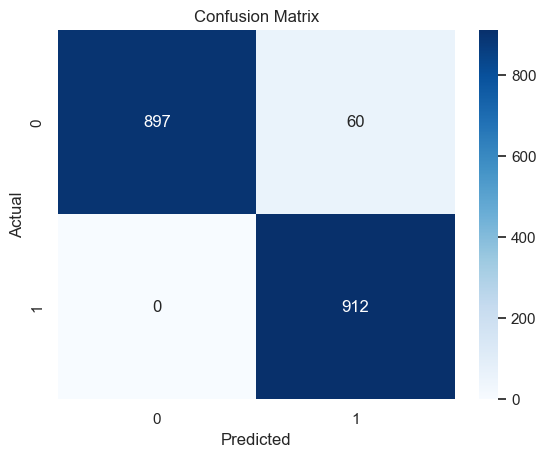

In [568]:
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### heatmap results
It is better to have a higher number of false positive predictions (identifying mushrooms as poisonous when they are not) rather than false negatives (misclassifying poisonous mushrooms as non-poisonous). This is because misclassifying a poisonous mushroom as non-poisonous could have severe consequences, potentially leading to harm or even fatalities if consumed.
Because of this, the model's current performance, where it predicts 65 mushrooms as poisonous when they are not, is relatively acceptable as long as it avoids misclassifying any non-poisonous mushrooms as safe. 

# illustrating the encoded data

In [569]:
# Perform one-hot encoding on the categorical features
encoded_data = pd.get_dummies(data)
encoded_data.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


# ROC curve

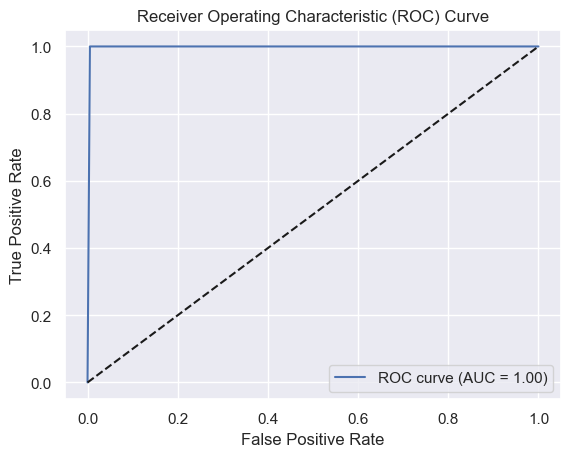

In [570]:


# Convert labels to numeric format
y_test_numeric = np.where(y_test == 'p', 1, 0)
# Calculate the probabilities of the predicted classes
y_probs = model.predict_proba(X_test)
positive_probs = y_probs[:, 1]  # Probability of positive class

# Compute the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test_numeric, positive_probs)

# Calculate the area under the ROC curve (AUC-ROC)
auc_roc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### ROC curve Results

This graph does not look right, this could be because of model issues, perhaps the Naive Bayesian model is not the best model for this dataset.


# Creating a KNN model

In [571]:


# Split the data into features (X) and target variable (y)
X = data.drop('class', axis=1)
y = data['class']

# Perform one-hot encoding to convert categorical variables into numerical representation
X_encoded = pd.get_dummies(X)

# Apply feature selection if necessary

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.23, random_state=43)

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed

# Train the classifier on the training data
knn_model.fit(X_train, y_train)

# Use the trained classifier to make predictions on the test data
y_pred = knn_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Apply cross-validation to evaluate the classifier's performance
cv_scores = cross_val_score(knn_model, X_encoded, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", np.mean(cv_scores))


Accuracy: 1.0
Cross-Validation Accuracy: 0.9150438044713909


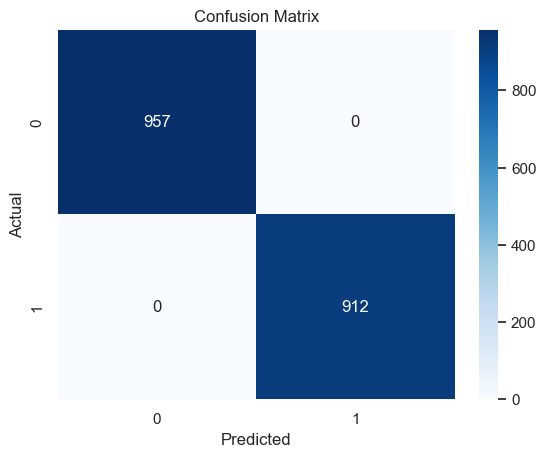

In [572]:
# Create a confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

KNN model is significantly more accurate than NaiveBayes model with this dataset